In [9]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

#import shap

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/user/thesis_ws/src/ML_Levers_Knobs/DATA/1D_KNOB_Tx+Tz_ScalNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000
N_CLASS = 6
DISP_LABELS = ["0", "1", "2", "3", "4", "5"]
input_shape = (WS_B, 2)

X_data shape: (629, 2000, 2)
y_data shape: (629,)
X_data.[0] shape:  (2000, 2)
TOTAL DATA: 629  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (377, 2000, 2)    ||  Dimensions of y_train: (377,)
Dimensions of X_test:  (126, 2000, 2)    ||  Dimensions of y_test:  (126,)
Dimensions of X_val:   (126, 2000, 2)    ||  Dimensions of y_val:   (126,)


# 1 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 197, 64)        │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,046 (1.55 MB)

 Trainable params: 407,046 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.2901 - loss: 1.6636 - val_accuracy: 0.5159 - val_loss: 1.2843
Epoch 2/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6307 - loss: 0.9789 - val_accuracy: 0.6111 - val_loss: 1.0727
Epoch 3/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7154 - loss: 0.7660 - val_accuracy: 0.6429 - val_loss: 0.9696
Epoch 4/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7833 - loss: 0.6319 - val_accuracy: 0.6825 - val_loss: 0.8448
Epoch 5/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.5038 - val_accuracy: 0.6190 - val_loss: 0.9401
Epoch 6/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8064 - loss: 0.4864 - val_accuracy: 0.7222 - val_loss: 0.7288
Epoch 7/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 0.3527 - val_accuracy: 0.7540 - val_loss: 0.6627
Epoch 8/22
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8904 - loss: 0.2915 - val_accuracy: 0.7540 - val_loss

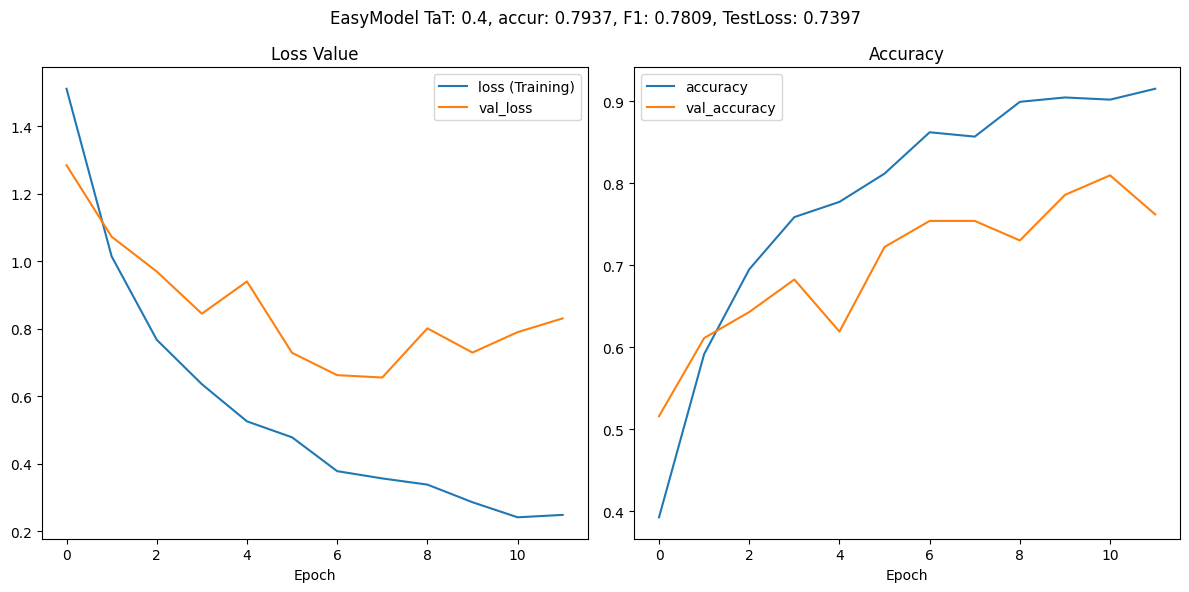

Train loss: 0.24894404411315918
Test val_loss: 0.8308145999908447
Train accuracy: 0.9151193499565125
Accuracy Score: 0.7936507936507936
F1 Score: 0.7809403495215389
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        29
         1.0       0.63      0.80      0.71        30
         2.0       0.82      0.79      0.81        29
         3.0       1.00      1.00      1.00        14
         4.0       0.73      0.89      0.80         9
         5.0       0.83      0.33      0.48        15

    accuracy                           0.79       126
   macro avg       0.82      0.79      0.78       126
weighted avg       0.81      0.79      0.79       126



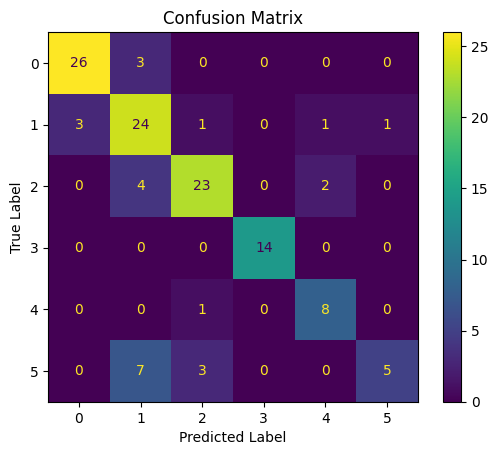

In [10]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', input_shape=input_shape))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Flatten())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=22, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# <span style="color:red;"> PLOT F1 SCORE AND F1 WRT ALL the THRESHOLDS</span>


# 2 CONVs 

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 498, 256)       │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 249, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 246, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 123, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 15744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,007,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,646 (4.37 MB)

 Trainable params: 1,144,646 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.3371 - loss: 1.5790 - val_accuracy: 0.5397 - val_loss: 1.1573
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6058 - loss: 1.0417 - val_accuracy: 0.6032 - val_loss: 0.9902
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7174 - loss: 0.7415 - val_accuracy: 0.6746 - val_loss: 0.9716
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7519 - loss: 0.6297 - val_accuracy: 0.7381 - val_loss: 0.8011
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7882 - loss: 0.5233 - val_accuracy: 0.7143 - val_loss: 0.7932
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7800 - loss: 0.4779 - val_accuracy: 0.7063 - val_loss: 1.1121
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8279 - loss: 0.5351 - val_accuracy: 0.7222 - val_loss: 0.8462
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8578 - loss: 0.3425 - val_accuracy: 0.7222 - val_lo

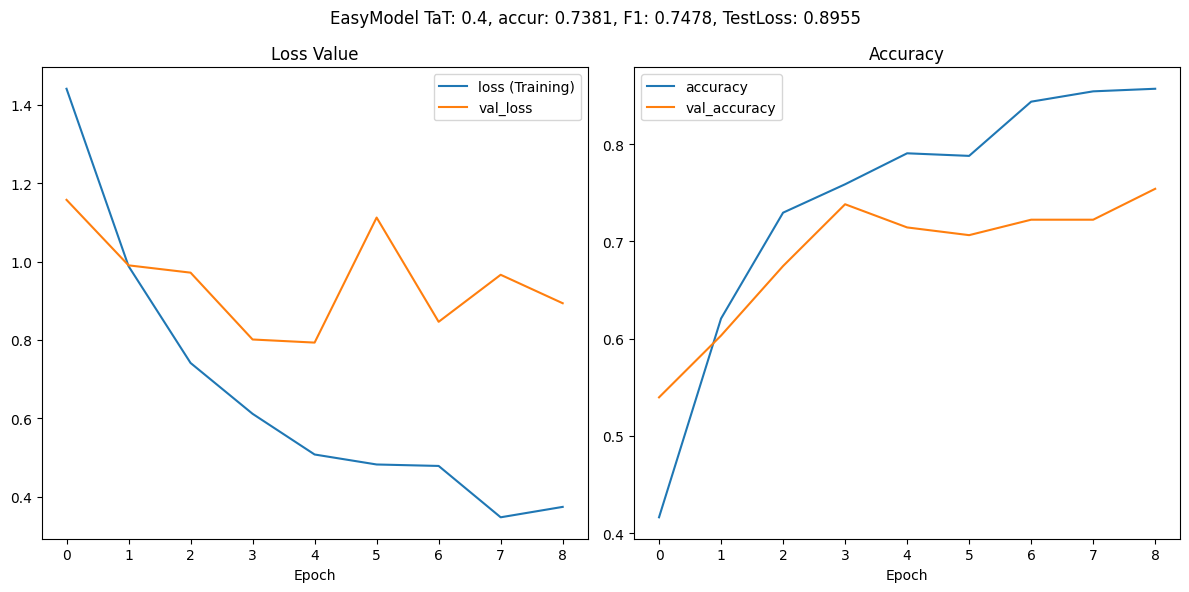

Train loss: 0.3741185665130615
Test val_loss: 0.893597424030304
Train accuracy: 0.8567638993263245
Accuracy Score: 0.7380952380952381
F1 Score: 0.7478057656629086
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.79      0.84        29
         1.0       0.57      0.77      0.66        30
         2.0       0.85      0.59      0.69        29
         3.0       0.86      0.86      0.86        14
         4.0       0.60      1.00      0.75         9
         5.0       0.82      0.60      0.69        15

    accuracy                           0.74       126
   macro avg       0.76      0.77      0.75       126
weighted avg       0.77      0.74      0.74       126



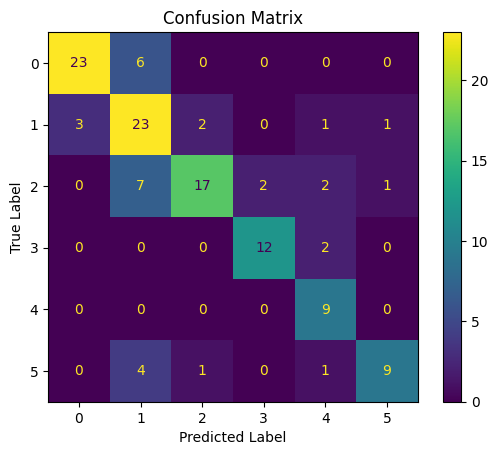

In [11]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=256, kernel_size=10, strides=4, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    #model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# model_name = "1D_LEVER_2Cnv_96"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3 CONVs

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 99, 256)        │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 49, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 11, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 4, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,574 (1.33 MB)

 Trainable params: 349,574 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.2594 - loss: 1.6854 - val_accuracy: 0.3095 - val_loss: 1.4927
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4462 - loss: 1.3485 - val_accuracy: 0.5238 - val_loss: 1.0778
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5984 - loss: 1.0282 - val_accuracy: 0.5476 - val_loss: 1.0862
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6125 - loss: 0.9397 - val_accuracy: 0.5556 - val_loss: 1.0130
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6700 - loss: 0.7627 - val_accuracy: 0.6270 - val_loss: 0.8990
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7173 - loss: 0.7195 - val_accuracy: 0.5952 - val_loss: 0.9919
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7175 - loss: 0.6638 - val_accuracy: 0.6587 - val_loss: 0.9052
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7683 - loss: 0.5476 - val_accuracy: 0.6111 - val_los

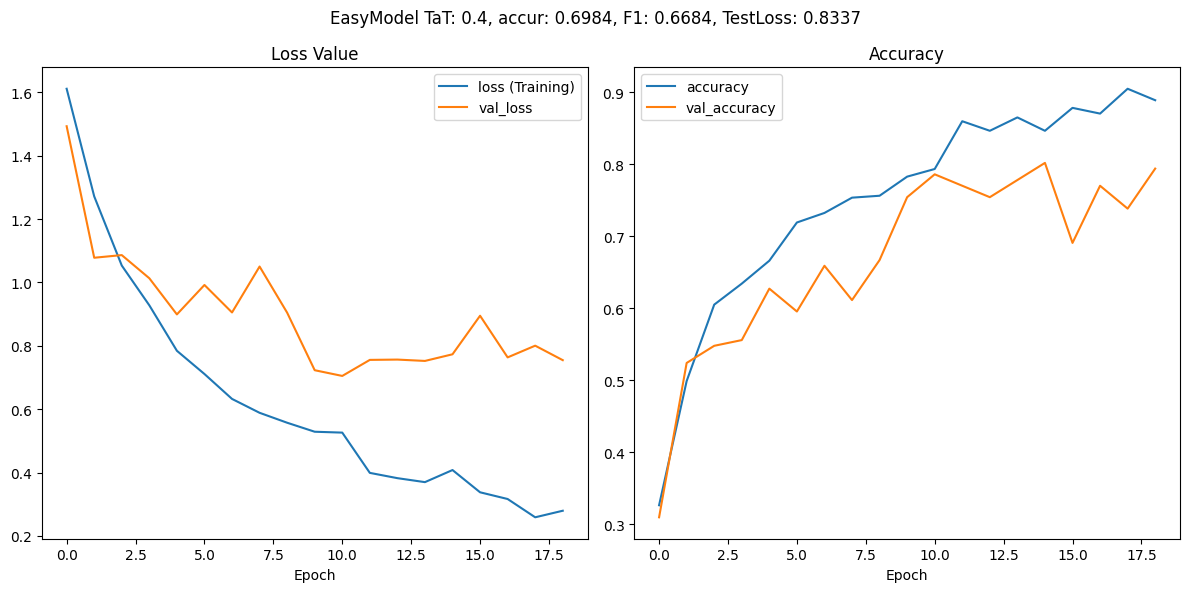

Train loss: 0.27965444326400757
Test val_loss: 0.7547121644020081
Train accuracy: 0.8885941505432129
Accuracy Score: 0.6984126984126984
F1 Score: 0.6684230321758925
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.90      0.91        29
         1.0       0.80      0.67      0.73        30
         2.0       0.58      0.72      0.65        29
         3.0       1.00      0.64      0.78        14
         4.0       0.56      1.00      0.72         9
         5.0       0.25      0.20      0.22        15

    accuracy                           0.70       126
   macro avg       0.69      0.69      0.67       126
weighted avg       0.72      0.70      0.70       126



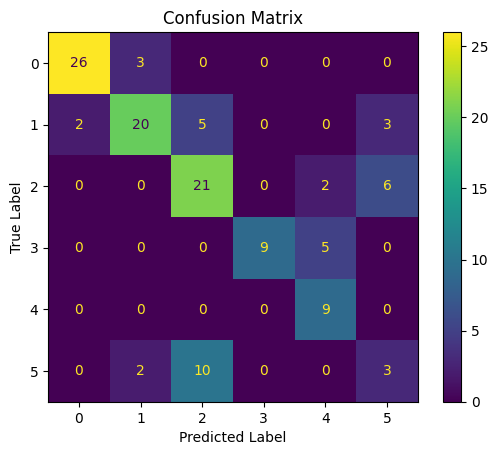

In [13]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(256, kernel_size=40, strides=20, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=8, strides=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    #model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_CLASS, activation='softmax'))

    return model
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 4 CONVs or Still "COMPLEX"

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_23 (Conv1D)              │ (None, 496, 256)       │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 248, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 59, 256)        │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 59, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 52, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 23, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,399,942 (5.34 MB)

 Trainable params: 1,399,942 (5.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.2474 - loss: 1.6996 - val_accuracy: 0.2460 - val_loss: 1.5993
Epoch 2/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3855 - loss: 1.4187 - val_accuracy: 0.5079 - val_loss: 1.2210
Epoch 3/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5206 - loss: 1.1410 - val_accuracy: 0.5794 - val_loss: 1.0510
Epoch 4/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6848 - loss: 0.8949 - val_accuracy: 0.6746 - val_loss: 0.8952
Epoch 5/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7063 - loss: 0.7343 - val_accuracy: 0.6587 - val_loss: 0.8435
Epoch 6/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7690 - loss: 0.6399 - val_accuracy: 0.6508 - val_loss: 0.9338
Epoch 7/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7940 - loss: 0.5159 - val_accuracy: 0.7460 - val_loss: 0.7912
Epoch 8/32
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7952 - loss: 0.4760 - val_accuracy: 0.6905 - 

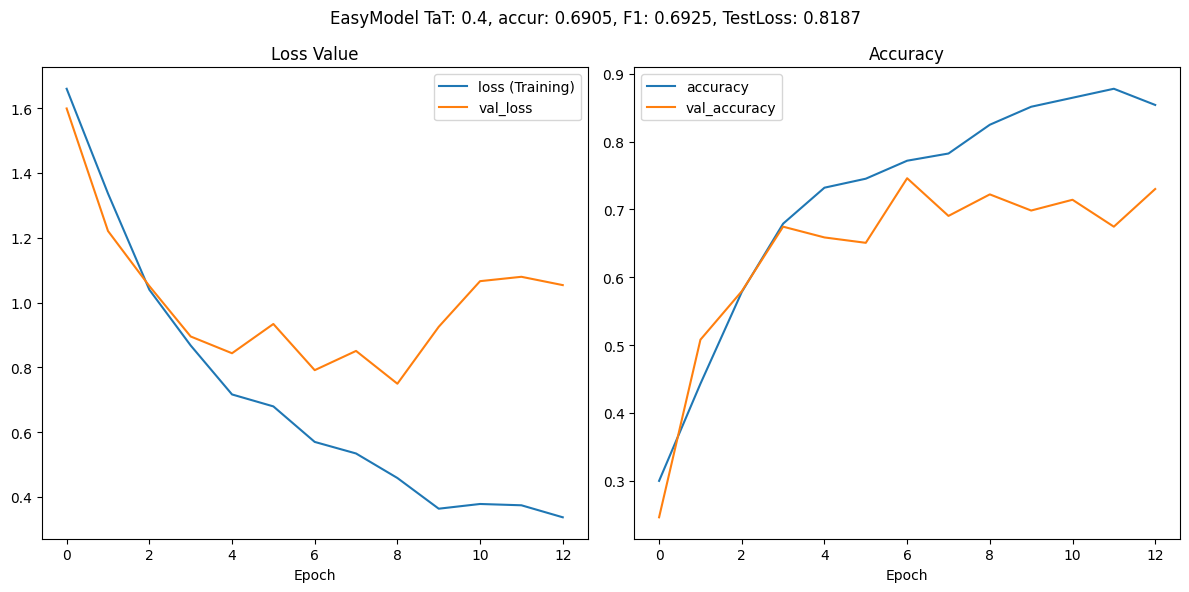

Train loss: 0.3368864059448242
Test val_loss: 1.0538417100906372
Train accuracy: 0.8541114330291748
Accuracy Score: 0.6904761904761905
F1 Score: 0.6924810502396709
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.79      0.82        29
         1.0       0.61      0.67      0.63        30
         2.0       0.66      0.66      0.66        29
         3.0       1.00      0.71      0.83        14
         4.0       0.62      0.89      0.73         9
         5.0       0.50      0.47      0.48        15

    accuracy                           0.69       126
   macro avg       0.70      0.70      0.69       126
weighted avg       0.71      0.69      0.69       126



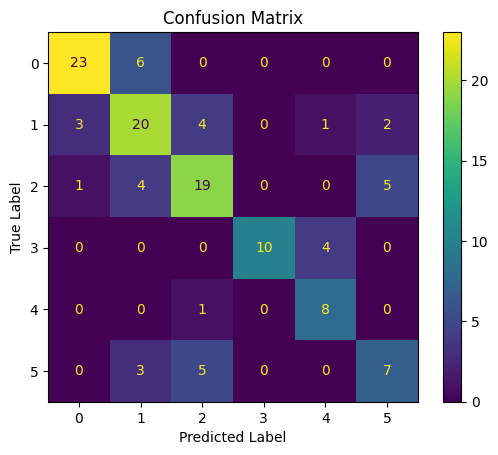

In [14]:
def build_easyModel():
    model = Sequential()
    
    model.add(Conv1D(filters=256, kernel_size=20, strides=4, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')) #LeakyReLU(alpha=0.001)
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(filters=128, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    #model.add(GlobalMaxPooling1D())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(N_CLASS, activation='softmax'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=32, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1) 

f1 = f1_score(y_test, y_pred_labels, average='macro') 
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5 CONVS